Calculating the gain using the peaks extracted from just the Polya model fitted to the integral histograms.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import floor, log10

#graph formatting
def fmt_sig_figs(val, n=2):
    if val == 0:
        return "0"
    mag = floor(log10(abs(val)))
    rounded_val = round(val, -int(mag - (n - 1)))
    return f"{rounded_val:g}"

def format_scientific_latex(val, err, n=2):
    if err <= 0 or val == 0:
        return f"{val:.1e} \\pm {err:.1e}"

    exponent = floor(log10(abs(val)))
    factor = 10**exponent
    scaled_val = val / factor
    scaled_err = err / factor

    return (f"({scaled_val:.{n}f} \\pm {scaled_err:.{n}f})"
            f"\\times 10^{{{exponent}}}")


In [10]:
#load the csvs with the peak information

spe_df = pd.read_csv('PMT1_spe_polya_peak_positions.csv')
darkrate_df = pd.read_csv('PMT1_DR_polya_peak_positions.csv')

#discard non-physical events
spe_df = spe_df[spe_df['polya_peak_pC'] > 0].reset_index(drop=True)
darkrate_df = darkrate_df[darkrate_df['polya_peak_pC'] > 0].reset_index(drop=True)

print('SPE')
print(spe_df)
print('DARKRATE')
print(darkrate_df)

#make 'None' if want to consider all points in the fit
#the ignored voltages will not be considered in the power law fit but will appear as crosses on the graph.
ignore_voltage = None

SPE
   voltage  polya_peak_pC  polya_peak_error_pC
0     1800       0.845142             0.074592
1     1850       1.117322             0.101454
2     1900       1.361250             0.063294
3     1950       1.730165             0.196752
4     2000       2.414232             0.224646
DARKRATE
    voltage  polya_peak_pC  polya_peak_error_pC
0      1800       0.983652             0.030767
1      1800       0.881489             0.003338
2      1800       0.784666             0.051290
3      1800       0.886599             0.009847
4      1800       0.866541             0.033810
5      1850       1.147212             0.015708
6      1850       1.162335             0.015536
7      1850       1.152331             0.017335
8      1850       1.140744             0.022592
9      1850       1.126072             0.038877
10     1900       1.506051             0.012152
11     1900       1.462737             0.009860
12     1900       1.466940             0.010203
13     1900       1.459074       

In [11]:
#add gain columns to the data frames

def add_gain_columns(df):
    df=df.copy()
    df['gain'] = (df['polya_peak_pC']*(1e-12)/(1.6e-19))
    df['gain_error'] = (df['polya_peak_error_pC']*(1e-12)/(1.6e-19))
    return df

spe_df = add_gain_columns(spe_df)
darkrate_df = add_gain_columns(darkrate_df)

In [12]:
#find mean gain for each voltage in case of multiple trials

def average_gain_per_voltage(df):
    grouped = df.groupby('voltage')
    mean_gain = grouped['gain'].mean()
    mean_gain_err = grouped['gain_error'].apply(lambda errs: np.sqrt(np.sum(errs**2)) / len(errs)
    )
    print(mean_gain_err)
    
    out = pd.DataFrame({'voltage': mean_gain.index,
        'gain': mean_gain.values,
        'gain_error': mean_gain_err.values})
    
    return out.sort_values('voltage')

spe_avg_gain = average_gain_per_voltage(spe_df)
print(spe_avg_gain)
darkrate_avg_gain = average_gain_per_voltage(darkrate_df)
print(darkrate_avg_gain)

voltage
1800    4.661981e+05
1850    6.340871e+05
1900    3.955892e+05
1950    1.229701e+06
2000    1.404035e+06
Name: gain_error, dtype: float64
   voltage          gain    gain_error
0     1800  5.282135e+06  4.661981e+05
1     1850  6.983265e+06  6.340871e+05
2     1900  8.507815e+06  3.955892e+05
3     1950  1.081353e+07  1.229701e+06
4     2000  1.508895e+07  1.404035e+06
voltage
1800    86858.898604
1850    66267.056958
1900    27360.554849
1950    92027.813107
2000    65479.927347
Name: gain_error, dtype: float64
   voltage          gain    gain_error
0     1800  5.503683e+06  86858.898604
1     1850  7.160867e+06  66267.056958
2     1900  9.243866e+06  27360.554849
3     1950  1.329917e+07  92027.813107
4     2000  2.157370e+07  65479.927347


In [13]:
#gain model and fitting
def gain_model(V, A, B):
    return A * V**(14 * B)

def fit_gain_curve(voltage, gain, gain_err, ignore_voltage):
    mask = np.ones_like(voltage, dtype=bool)

    if ignore_voltage is not None:
        mask &= voltage != ignore_voltage
    
    
    p0 = [5e-26, 0.7] #initial guesses
    
    '''
    bounds = (
        [1e-27, 0],   # lower bounds: A, B
        [1e-22, 1]    # upper bounds: A, B
    )
    popt, pcov = curve_fit(
        gain_model,
        voltage[mask],
        gain[mask],
        sigma=gain_err[mask],
        absolute_sigma=True,
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )
    '''
    popt, pcov = curve_fit(
        gain_model,
        voltage[mask],
        gain[mask],
        sigma=gain_err[mask],
        absolute_sigma=True,
        p0=p0,
        maxfev=10000
    )

    A_fit, B_fit = popt
    err_A, err_B = np.sqrt(np.diag(pcov))

    return A_fit, B_fit, err_A, err_B


A_spe, B_spe, errA_spe, errB_spe = fit_gain_curve(
    spe_avg_gain['voltage'].values,
    spe_avg_gain['gain'].values,
    spe_avg_gain['gain_error'].values,
    ignore_voltage
)

A_dark, B_dark, errA_dark, errB_dark = fit_gain_curve(
    darkrate_avg_gain['voltage'].values,
    darkrate_avg_gain['gain'].values,
    darkrate_avg_gain['gain_error'].values,
    ignore_voltage
)


V_plot = np.linspace(
    min(spe_avg_gain['voltage'].min(), darkrate_avg_gain['voltage'].min()),max(spe_avg_gain['voltage'].max(), darkrate_avg_gain['voltage'].max()),300)


In [14]:
#compute chi squareds

def chi_squared(y_data, y_model, y_err, n_params):
    chi2 = np.sum(((y_data-y_model)/y_err)**2)
    dof = len(y_data)-n_params
    chi2_reduced = chi2/dof
    return chi2, chi2_reduced


y_spe_model = gain_model(spe_avg_gain['voltage'].values, A_spe, B_spe)
chi2_spe, chi2_red_spe = chi_squared(
    spe_avg_gain['gain'].values,
    y_spe_model,
    spe_avg_gain['gain_error'].values,
    n_params=2
)


y_dark_model = gain_model(darkrate_avg_gain['voltage'].values,A_dark,B_dark)
chi2_dark, chi2_red_dark = chi_squared(
    darkrate_avg_gain['gain'].values,
    y_dark_model,
    darkrate_avg_gain['gain_error'].values,
    n_params=2
)

#residual calculations
spe_model_at_points = gain_model(
    spe_avg_gain['voltage'].values, A_spe, B_spe
)
dark_model_at_points = gain_model(
    darkrate_avg_gain['voltage'].values, A_dark, B_dark
)
residuals_spe = spe_avg_gain['gain'].values - spe_model_at_points
residuals_dark = darkrate_avg_gain['gain'].values - dark_model_at_points


# --- SPE label ---
A_spe_tex = format_scientific_latex(A_spe, errA_spe, n=2)
B_spe_tex = format_scientific_latex(B_spe, errB_spe, n=2)

label_spe = (
    r'SPE fit: $G = A V^{14B}$'
    f'\n$A = {A_spe_tex}$'
    f'\n$B = {B_spe_tex}$'
    f'\n$\\chi^2_\\nu = {fmt_sig_figs(chi2_red_spe, 2)}$'
)

# --- Dark rate label ---
A_dark_tex = format_scientific_latex(A_dark, errA_dark, n=2)
B_dark_tex = format_scientific_latex(B_dark, errB_dark, n=2)

label_dark = (
    r'Dark rate fit: $G = A V^{14B}$'
    f'\n$A = {A_dark_tex}$'
    f'\n$B = {B_dark_tex}$'
    f'\n$\\chi^2_\\nu = {fmt_sig_figs(chi2_red_dark, 2)}$'
)


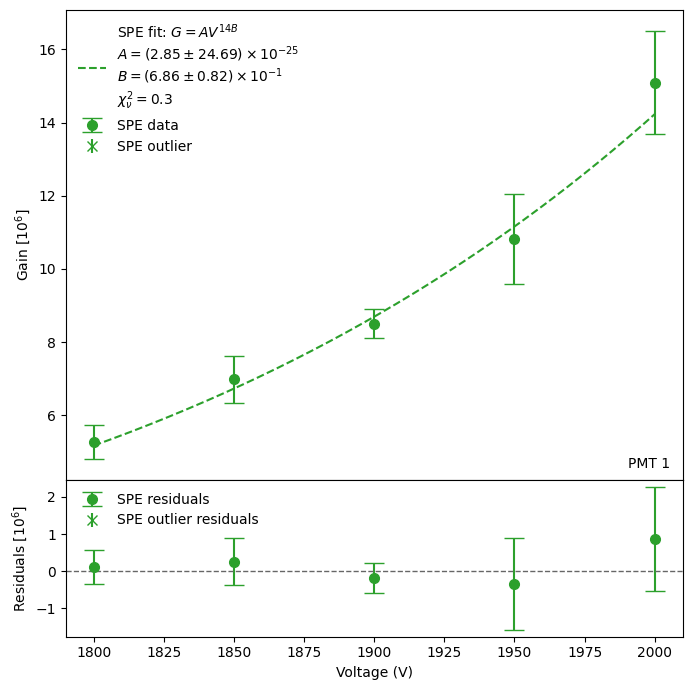

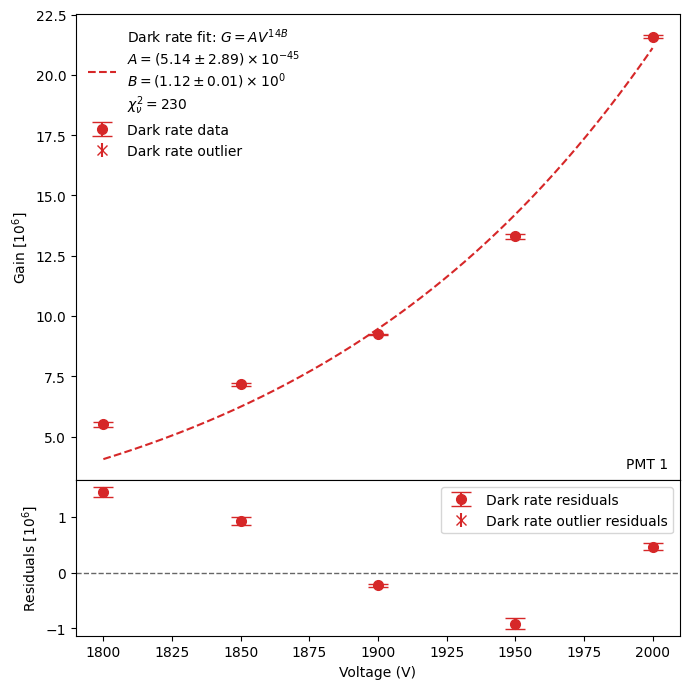

In [15]:
#plot gain curves and gain model = A V^14B separately
mask_spe = spe_avg_gain['voltage'] != ignore_voltage
mask_dark = darkrate_avg_gain['voltage'] != ignore_voltage
mask_ignored_spe = ~mask_spe
mask_ignored_dark = ~mask_dark


fig, (ax, ax_res) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(7, 7), 
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}
)
ax.errorbar(
    spe_avg_gain['voltage'][mask_spe],
    spe_avg_gain['gain'][mask_spe]/1e6,
    yerr=spe_avg_gain['gain_error'][mask_spe]/1e6,
    fmt='o',
    markersize=7,
    capsize=7,
    color='tab:green',
    ecolor='tab:green',
    label='SPE data'
)
ax_res.errorbar(
    spe_avg_gain['voltage'][mask_spe],
    residuals_spe[mask_spe]/1e6,
    yerr=spe_avg_gain['gain_error'][mask_spe]/1e6,
    fmt='o',
    markersize=7,
    capsize=7,
    color='tab:green',
    label='SPE residuals'
)

ax.errorbar(
    spe_avg_gain['voltage'][mask_ignored_spe],
    spe_avg_gain['gain'][mask_ignored_spe]/1e6,
    yerr=spe_avg_gain['gain_error'][mask_ignored_spe]/1e6,
    fmt='x',
    markersize=7,
    capsize=7,
    color='tab:green',
    label='SPE outlier'
)
ax_res.errorbar(
    spe_avg_gain['voltage'][mask_ignored_spe],
    residuals_spe[mask_ignored_spe]/1e6,
    yerr=spe_avg_gain['gain_error'][mask_ignored_spe]/1e6,
    fmt='x',
    markersize=7,
    capsize=7,
    color='tab:green',
    label='SPE outlier residuals'
)

ax.plot(
    V_plot,
    gain_model(V_plot, A_spe, B_spe)/1e6,
    '--',
    color='tab:green',
    label=label_spe
)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Gain [$10^6$]')
ax.text(
    0.98, 0.02,
    'PMT 1',
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    fontsize='medium'
)
#plt.grid(alpha=0.3)
ax.legend(frameon=False)
ax_res.axhline(0, color='0.4', linestyle='--', linewidth=1)

ax_res.set_xlabel('Voltage (V)')
ax_res.set_ylabel('Residuals [$10^6$]')
ax_res.legend(frameon=False)

plt.tight_layout()
plt.show()




fig, (ax, ax_res) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(7, 7), 
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}
)
ax.errorbar(
    darkrate_avg_gain['voltage'][mask_dark],
    darkrate_avg_gain['gain'][mask_dark]/1e6,
    yerr=darkrate_avg_gain['gain_error'][mask_dark]/1e6,
    fmt='o',
    markersize=7,
    capsize=7,
    color='tab:red',
    ecolor='tab:red',
    label='Dark rate data'
)
ax.errorbar(
    darkrate_avg_gain['voltage'][mask_ignored_dark],
    darkrate_avg_gain['gain'][mask_ignored_dark]/1e6,
    yerr=darkrate_avg_gain['gain_error'][mask_ignored_dark]/1e6,
    fmt='x',
    markersize=7,
    capsize=7,
    color='tab:red',
    label='Dark rate outlier'
)
ax_res.errorbar(
    darkrate_avg_gain['voltage'][mask_dark],
    residuals_dark[mask_dark]/1e6,
    yerr=darkrate_avg_gain['gain_error'][mask_dark]/1e6,
    fmt='o',
    markersize=7,
    capsize=7,
    color='tab:red',
    label='Dark rate residuals'
)
ax_res.errorbar(
    darkrate_avg_gain['voltage'][mask_ignored_dark],
    residuals_dark[mask_ignored_dark]/1e6,
    yerr=darkrate_avg_gain['gain_error'][mask_ignored_dark]/1e6,
    fmt='x',
    markersize=7,
    capsize=7,
    color='tab:red',
    label='Dark rate outlier residuals'
)
ax.plot(
    V_plot,
    gain_model(V_plot, A_dark, B_dark)/1e6,
    '--',
    color='tab:red',
    label=label_dark
)

ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Gain [$10^6$]')
ax.text(
    0.98, 0.02,
    'PMT 1',
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    fontsize='medium'
)
#plt.grid(alpha=0.3)
ax.legend(frameon=False)
ax_res.axhline(0, color='0.4', linestyle='--', linewidth=1)

ax_res.set_xlabel('Voltage (V)')
ax_res.set_ylabel('Residuals [$10^6$]')
ax_res.legend()
plt.tight_layout()
plt.show()


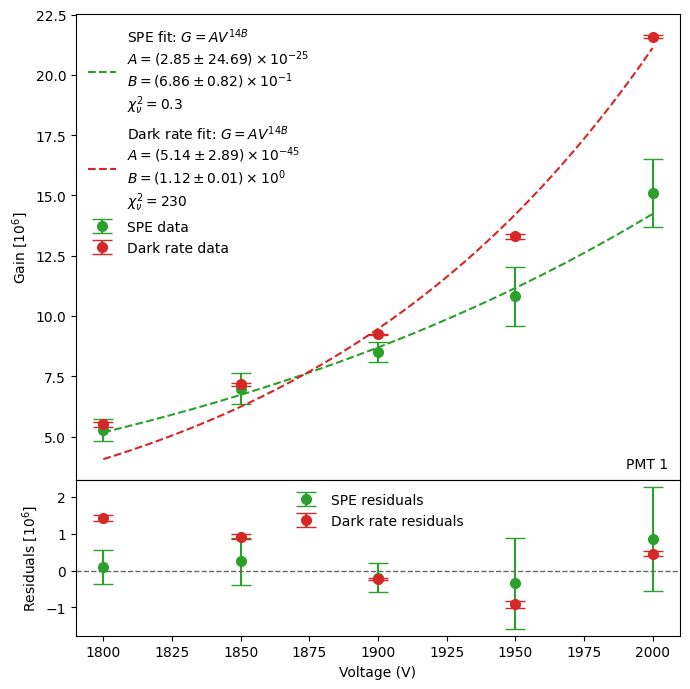

In [16]:
#plot gain curves and gain models = A V^14B together
fig, (ax, ax_res) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(7, 7), 
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}
)

#make ignored voltage appear as a cross
mask_spe = spe_avg_gain['voltage'] != ignore_voltage
mask_dark = darkrate_avg_gain['voltage'] != ignore_voltage
mask_ignored_spe = ~mask_spe
mask_ignored_dark = ~mask_dark


ax.errorbar(
    spe_avg_gain['voltage'][mask_spe],
    spe_avg_gain['gain'][mask_spe]/1e6,
    yerr=spe_avg_gain['gain_error'][mask_spe]/1e6,
    fmt='o',
    markersize=7,
    capsize=7,
    color='tab:green',
    ecolor='tab:green',
    label='SPE data'
)
ax.plot(
    V_plot,
    gain_model(V_plot, A_spe, B_spe)/1e6,
    '--',
    color='tab:green',
    label=label_spe
)

ax.errorbar(
    darkrate_avg_gain['voltage'][mask_dark],
    darkrate_avg_gain['gain'][mask_dark]/1e6,
    yerr=darkrate_avg_gain['gain_error'][mask_dark]/1e6,
    fmt='o',
    markersize=7,
    capsize=7,
    color='tab:red',
    ecolor='tab:red',
    label='Dark rate data'
)
ax.plot(
    V_plot,
    gain_model(V_plot, A_dark, B_dark)/1e6,
    '--',
    color='tab:red',
    label=label_dark
)
ax.text(
    0.98, 0.02,
    'PMT 1',
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    fontsize='medium'
)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Gain [$10^6$]')
#plt.grid(alpha=0.3)
ax.legend(frameon=False)

ax_res.errorbar(
    spe_avg_gain['voltage'][mask_spe],
    residuals_spe[mask_spe]/1e6,
    yerr=spe_avg_gain['gain_error'][mask_spe]/1e6,
    fmt='o',
    markersize=7,
    capsize=7,
    color='tab:green',
    label='SPE residuals'
)

ax_res.errorbar(
    darkrate_avg_gain['voltage'][mask_dark],
    residuals_dark[mask_dark]/1e6,
    yerr=darkrate_avg_gain['gain_error'][mask_dark]/1e6,
    fmt='o',
    markersize=7,
    capsize=7,
    color='tab:red',
    label='Dark rate residuals'
)

# Zero line
ax_res.axhline(0, color='0.4', linestyle='--', linewidth=1)

ax_res.set_xlabel('Voltage (V)')
ax_res.set_ylabel('Residuals [$10^6$]')
ax_res.legend(frameon=False)


plt.tight_layout()
plt.show()

